In [13]:
import os
import json
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon
import pandas as pd
import numpy as np
import xarray as xr
import rioxarray as rxr
import geoviews as gv
import geoviews.feature as gf
import hvplot.pandas
import s3fs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from multiprocessing import Pool, cpu_count
import dask

In [14]:
# import dask.multiprocessing
# dask.config.set(scheduler='multiprocessing',num_workers = 12);  # Enable multicore parallelism

## Define functions from Emma's its_live tutorial

In [79]:
# THIS IS FROM EMMA's TUTORIAL https://github.com/e-marshall/itslivetools/blob/main/itslivetools/access.py
def find_granule_by_point(input_point, label='single_point'):
    '''returns url for the granule (zarr datacube) containing a specified point. point must be passed in epsg:4326
    '''
    catalog = gpd.read_file('https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json')

    #make shapely point of input point
    p = gpd.GeoSeries([Point(input_point[0], input_point[1])],crs='EPSG:4326')
    #make gdf of point
    gdf = gdf = gpd.GeoDataFrame({'label': f'{label}', 
                                  'geometry':p})

    #find row of granule 
    granule = catalog.sjoin(gdf, how='inner')

    url = granule['zarr_url'].values[0]
    return url
    
def read_in_s3(http_url, chunks='auto'):
    ''' does some string formatting from zarr url and returns xarray dataset
    '''

    s3_url = http_url.replace('http','s3')
    s3_url = s3_url.replace('.s3.amazonaws.com','')

    datacube = xr.open_dataset(s3_url, engine='zarr',
                               storage_options={'anon':True},
                               chunks=chunks)

    # datacube = rxr.open_rasterio(s3_url, engine='zarr',
    #                            storage_options={'anon':True},
    #                            chunks=chunks)
    
    return datacube


In [80]:
catalog = gpd.read_file('https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json') # ITS_LIVE data catalog where all the paths are defined

In [81]:
catalog

,fill-opacity,fill,roi_percent_coverage,geometry_epsg,datacube_exist,zarr_url,epsg,FULL_NAME,RGI_CODE,geometry
0,0.984866,red,1.513354,"{'type': 'Polygon', 'coordinates': [[[400000, ...",1,http://its-live-data.s3.amazonaws.com/datacube...,32718,Southern Andes,17,"POLYGON ((-76.41134 -50.54338, -75.00000 -50.5..."
1,0.956741,red,4.325908,"{'type': 'Polygon', 'coordinates': [[[400000, ...",1,http://its-live-data.s3.amazonaws.com/datacube...,32718,Southern Andes,17,"POLYGON ((-76.38517 -49.64426, -75.00000 -49.6..."
2,0.941388,red,5.861168,"{'type': 'Polygon', 'coordinates': [[[500000, ...",1,http://its-live-data.s3.amazonaws.com/datacube...,32718,Southern Andes,17,"POLYGON ((-75.00000 -54.14810, -73.46930 -54.1..."
3,0.794830,red,20.516970,"{'type': 'Polygon', 'coordinates': [[[500000, ...",1,http://its-live-data.s3.amazonaws.com/datacube...,32718,Southern Andes,17,"POLYGON ((-75.00000 -53.24927, -73.50155 -53.2..."
4,0.881647,red,11.835322,"{'type': 'Polygon', 'coordinates': [[[500000, ...",1,http://its-live-data.s3.amazonaws.com/datacube...,32718,Southern Andes,17,"POLYGON ((-75.00000 -52.35029, -73.53212 -52.3..."
...,...,...,...,...,...,...,...,...,...,...
3081,0.430030,red,56.997012,"{'type': 'Polygon', 'coordinates': [[[2600000,...",1,http://its-live-data.s3.amazonaws.com/datacube...,3031,Antarctic and Subantarctic,19,"POLYGON ((96.58195 -66.24424, 96.34019 -65.368..."
3082,0.926190,red,7.381008,"{'type': 'Polygon', 'coordinates': [[[2600000,...",1,http://its-live-data.s3.amazonaws.com/datacube...,3031,Antarctic and Subantarctic,19,"POLYGON ((94.39871 -66.32873, 94.23640 -65.449..."
3083,0.963654,red,3.634587,"{'type': 'Polygon', 'coordinates': [[[2600000,...",1,http://its-live-data.s3.amazonaws.com/datacube...,3031,Antarctic and Subantarctic,19,"POLYGON ((87.79740 -66.37959, 87.87890 -65.498..."
3084,0.803025,red,19.697531,"{'type': 'Polygon', 'coordinates': [[[2700000,...",1,http://its-live-data.s3.amazonaws.com/datacube...,3031,Antarctic and Subantarctic,19,"POLYGON ((98.42697 -65.25528, 98.13010 -64.386..."


In [82]:
# KUJ polygon from Kevin
# Read in polygon and get centroid to join with its_live data catalog
path = './geoms/2020_12_11_term_polygon.shp'
kuj_poly = gpd.read_file(path)
kuj_centroid = kuj_poly.centroid
kuj_centroid = gpd.GeoDataFrame(geometry=kuj_centroid,crs=4326)
granule = catalog.sjoin(kuj_centroid, how='inner')
url = granule['zarr_url'].values[0]

/tmp/ipykernel_26128/1985992690.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  kuj_centroid = kuj_poly.centroid


In [83]:
granule
# the granule contains ALL of the velocity raster data for the region around
# your assigned centroid point. Each mid_date is a separate raster.

,fill-opacity,fill,roi_percent_coverage,geometry_epsg,datacube_exist,zarr_url,epsg,FULL_NAME,RGI_CODE,geometry,index_right
1270,0.0,red,100.0,"{'type': 'Polygon', 'coordinates': [[[-200000,...",1,http://its-live-data.s3.amazonaws.com/datacube...,3413,Greenland Periphery,5,"POLYGON ((-50.19443 69.81052, -47.60256 69.871...",0


In [84]:
kuj_vels = read_in_s3(url)
kuj_vels = kuj_vels.chunk({"mid_date": len(kuj_vels.mid_date)}) # setting the mid_date chunksize to the time dimensions helps A LOT
kuj_vels = kuj_vels.sortby('mid_date')

In [78]:
cpus = cpu_count() 
manual_chunk = int(kuj_vels.mid_date.shape[0]/cpus)
kuj_vels = kuj_vels.chunk({"mid_date": manual_chunk}) # setting the mid_date chunksize to the time dimensions helps A LOT
kuj_vels = kuj_vels.sortby('mid_date')


In [55]:
# read in all terminus-based polygons for the glacier
glacier = 'KUJ'
terminus_poly_dir = glacier+'_polygons/'

## Check data quality 
Filter data so we're only keeping: data pairs that are less than 15 days apart, data that has a terminus pick within 30 days, and rasters that have velocity data in at least 90% of the polygon.

In [23]:
# remove data where the image pairs are more than 15 days apart
date_dt_threshold = 1296000000000000 # Define the threshold in nanoseconds (15 days)

# set the threshold as an xarray
date_dt_threshold = xr.DataArray(date_dt_threshold, coords=kuj_vels.date_dt.coords, dims=kuj_vels.date_dt.dims)
date_dt_mask = kuj_vels.date_dt <= date_dt_threshold # Create a boolean mask based on the condition
date_dt_mask = date_dt_mask.compute(scheduler='processes')
kuj_vels_filt = kuj_vels.where(date_dt_mask, drop=True) # Apply the mask to filter the dataset

# print the data loss between the original dataset and the filtered
print('Original data rows: ', len(kuj_vels.mid_date))
print('Filtered data rows: ', len(kuj_vels_filt.mid_date))

Original data rows:  49475
Filtered data rows:  5684


In [24]:
# remove data with no terminus pick within 30 days
# List the dates of all the .shp files in the directory
files = os.listdir(terminus_poly_dir)
shp_files = [file for file in files if file.endswith('.shp')] # Filter only the .shp files
date_format = '%Y_%m_%d'
terminus_dates = [datetime.strptime(shp_file[:10], date_format) for shp_file in shp_files]
terminus_dates = [date.strftime('%Y-%m-%d') for date in terminus_dates]
terminus_dates = pd.to_datetime(terminus_dates)

time_window = timedelta(days=30) # Define the time window (30 days)
valid_indices = [] # empty list
# Iterate over each mid_date in kuj_vels_filt
for index, mid_date in enumerate(kuj_vels_filt.mid_date.values):
    mid_date = pd.to_datetime(mid_date)  # Convert to pandas datetime for comparison
    # Check if mid_date is within 30 days of any date in terminus_dates
    if any(abs(mid_date - date) <= time_window for date in terminus_dates):
        valid_indices.append(index)

# filter kuj_vels_filt
kuj_vels_filt = kuj_vels_filt.isel(mid_date=np.array(valid_indices))

# print the data loss between the original dataset and the filtered
print('Original data rows: ', len(kuj_vels.mid_date))
print('Filtered data rows: ', len(kuj_vels_filt.mid_date))

Original data rows:  49475
Filtered data rows:  4466


/home/laserglaciers/anaconda3/envs/its_live_tutorial/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [25]:
# setup variables into useful formats
kuj_vels_filt = kuj_vels_filt.rio.write_crs('EPSG:3413')
kuj_vels_filt.rio.transform()
pixel_mask_threshold = float(0.80) # ie- only keep data if __%+ of the polygon is there

In [ ]:
# Iterate over each mid_date in kuj_vels_filt_clip
saved_means       = []
saved_dates       = []
saved_coverage    = []
filtered_datasets = []
for mid_date in kuj_vels_filt.mid_date.values:
    mid_date = pd.to_datetime(mid_date)  # Convert to pandas datetime
    
    # Find the nearest date in terminus_dates
    nearest_date = min(terminus_dates, key=lambda x: abs(x - mid_date))
    
    # Formulate the filename based on the nearest date
    filename = nearest_date.strftime('%Y_%m_%d_term_polygon.shp')
    filepath = os.path.join(terminus_poly_dir, filename)
    
    # Import the related .shp file as clip_poly
    clip_poly = gpd.read_file(filepath)
    kuj_poly_3413 = clip_poly.to_crs(3413)
    kuj_vels_filt_clip = kuj_vels_filt.rio.clip(kuj_poly_3413.geometry.values,
                                                kuj_poly_3413.crs, drop=True, invert=False)
    
    # Compute pixel_mask
    data = kuj_vels_filt_clip.v.sel(mid_date=mid_date)
    pixel_area = data.count(dim=["x", "y"]) * 120 * 120
    area = kuj_poly_3413.area
    pixel_mask = np.divide(pixel_area,area[0])
    # pixel_mask = pixel_area / kuj_poly_3413.area
    
    # Check if all values in pixel_mask meet the condition
    # if (pixel_mask > pixel_mask_threshold).all():
    # mean_value = np.nanmean(kuj_vels_filt_clip.v.sel(mid_date=mid_date).values)
    mean_value = kuj_vels_filt_clip.v.sel(mid_date=mid_date).mean(skipna=True)
    
    # filtered_datasets.append(kuj_vels_filt_clip)
    # saved_means.append(mean_value)
    # saved_dates.append(mid_date)
    # saved_coverage.append(pixel_mask)

# Combine the filtered variables into a single DataArray
# kuj_vels_final = xr.concat(filtered_datasets, dim='mid_date')

In [26]:

def list_outputs(kuj_vels_filt):
    # Iterate over each mid_date in kuj_vels_filt_clip
    saved_means       = []
    saved_dates       = []
    saved_coverage    = []
    filtered_datasets = []
    for mid_date in kuj_vels_filt.mid_date.values:
        mid_date = pd.to_datetime(mid_date)  # Convert to pandas datetime
        
        # Find the nearest date in terminus_dates
        nearest_date = min(terminus_dates, key=lambda x: abs(x - mid_date))
        
        # Formulate the filename based on the nearest date
        filename = nearest_date.strftime('%Y_%m_%d_term_polygon.shp')
        filepath = os.path.join(terminus_poly_dir, filename)
        
        # Import the related .shp file as clip_poly
        clip_poly = gpd.read_file(filepath)
        kuj_poly_3413 = clip_poly.to_crs(3413)
        kuj_vels_filt_clip = kuj_vels_filt.rio.clip(kuj_poly_3413.geometry.values,
                                                    kuj_poly_3413.crs, drop=True, invert=False)
        
        # Compute pixel_mask
        data = kuj_vels_filt_clip.v.sel(mid_date=mid_date)
        pixel_area = data.count(dim=["x", "y"]) * 120 * 120
        area = kuj_poly_3413.area
        pixel_mask = np.divide(pixel_area,area[0])
        # pixel_mask = pixel_area / kuj_poly_3413.area
        
        # Check if all values in pixel_mask meet the condition
        # if (pixel_mask > pixel_mask_threshold).all():
        # mean_value = np.nanmean(kuj_vels_filt_clip.v.sel(mid_date=mid_date).values)
        mean_value = kuj_vels_filt_clip.v.sel(mid_date=mid_date).mean(skipna=True)
        
        filtered_datasets.append(kuj_vels_filt_clip)
        saved_means.append(mean_value)
        saved_dates.append(mid_date)
        saved_coverage.append(pixel_mask)
    
    # Combine the filtered variables into a single DataArray
    # kuj_vels_final = xr.concat(filtered_datasets, dim='mid_date')

    return saved_means, saved_dates, saved_coverage

In [27]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers = 12)
c = Client(cluster)

vel_ts_list = []
for i in range(cpus):
    chunked_vel = kuj_vels.isel(mid_date=slice(i*manual_chunk,manual_chunk*(i+1))) # select the range of data from beginning to end of chunk size
    vel_ts_list.append(chunked_vel)

future = c.map(list_outputs, vel_ts_list)
results = c.gather(future)

/home/laserglaciers/anaconda3/envs/its_live_tutorial/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 49.05 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-02-06 18:33:22,704 - distributed.worker - WARNING - Compute Failed
Key:       list_outputs-6977dc93b2d7415fbd98474551c9b79a
Function:  list_outputs
args:      (<xarray.Dataset>
Dimensions:                     (mid_date: 4122, y: 834, x: 833)
Coordinates:
  * mid_date                    (mid_date) datetime64[ns] 2018-02-21T14:54:13...
  * x                           (x) float64 -1.999e+05 -1.997e+05 ... -1e+05
  * y                           (y) float64 -2.1e+06 -2.1e+06 ... -2.2e+06
Data variables: (12/60)
    M11                         (mid_date, y, x) float32 dask.array<chunksize=(4122, 20, 20), meta=np.ndarray>
    M11_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(4122,), meta=np.ndarray>
    M12

AttributeError: 'Dataset' object has no attribute 'rio'

2024-02-06 18:33:22,769 - distributed.worker - WARNING - Compute Failed
Key:       list_outputs-6894bba8062df097408c70d4fe47c3ff
Function:  list_outputs
args:      (<xarray.Dataset>
Dimensions:                     (mid_date: 4122, y: 834, x: 833)
Coordinates:
  * mid_date                    (mid_date) datetime64[ns] 2019-12-24T03:28:45...
  * x                           (x) float64 -1.999e+05 -1.997e+05 ... -1e+05
  * y                           (y) float64 -2.1e+06 -2.1e+06 ... -2.2e+06
Data variables: (12/60)
    M11                         (mid_date, y, x) float32 dask.array<chunksize=(4122, 20, 20), meta=np.ndarray>
    M11_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(4122,), meta=np.ndarray>
    M12                         (mid_date, y, x) float32 dask.array<chunksize=(4122, 20, 20), meta=np.ndarray>
    M12_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(4122,), meta=np.ndarray>
    acquisition_date_img1       (mid_date) datetime64[ns] dask.ar

In [87]:
vel_ts_list[0]

<xarray.Dataset>
Dimensions:                     (mid_date: 4122, y: 834, x: 833)
Coordinates:
  * mid_date                    (mid_date) datetime64[ns] 1984-10-21T14:23:16...
  * x                           (x) float64 -1.999e+05 -1.997e+05 ... -1e+05
  * y                           (y) float64 -2.1e+06 -2.1e+06 ... -2.2e+06
Data variables: (12/60)
    M11                         (mid_date, y, x) float32 dask.array<chunksize=(4122, 20, 20), meta=np.ndarray>
    M11_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(4122,), meta=np.ndarray>
    M12                         (mid_date, y, x) float32 dask.array<chunksize=(4122, 20, 20), meta=np.ndarray>
    M12_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(4122,), meta=np.ndarray>
    acquisition_date_img1       (mid_date) datetime64[ns] dask.array<chunksize=(4122,), meta=np.ndarray>
    acquisition_date_img2       (mid_date) datetime64[ns] dask.array<chunksize=(4122,), meta=np.ndarray>
    ...                          ...
    vy_error_modeled            (mid_date) float32 dask.array<chunksize=(4122,), meta=np.ndarray>
    vy_error_slow               (mid_date) float32 dask.array<chunksize=(4122,), meta=np.ndarray>
    vy_error_stationary         (mid_date) float32 dask.array<chunksize=(4122,), meta=np.ndarray>
    vy_stable_shift             (mid_date) float32 dask.array<chunksize=(4122,), meta=np.ndarray>
    vy_stable_shift_slow        (mid_date) float32 dask.array<chunksize=(4122,), meta=np.ndarray>
    vy_stable_shift_stationary  (mid_date) float32 dask.array<chunksize=(4122,), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               26-Sep-2023 03:06:33
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N70W040/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N70W040/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

Trying to get data before 2000: <br>
A 90% filter produced 897 rasters for KUJ, with the earliest one on 2002-05-03. <br>
A 85% filter produced 1211 rasters for KUJ, with the earliest one on 2001-05-11. <br>
A 80% filter pruduced 1412 raseters for KUJ, with the earliest one on 2000-05-01.

In [122]:
len(saved_means)

1412

In [124]:
saved_dates[0]

Timestamp('2000-05-01 14:52:50.674408960')

In [125]:
# reformat the saved lists before adding them to a df
saved_coverage_float  = []
saved_coverage_float  = [round(entry[0],3) for entry in saved_coverage]
saved_dates_formatted = pd.to_datetime(saved_dates, format="Timestamp('%Y-%m-%d %H:%M:%S.%f')").strftime('%Y-%m-%d')
saved_means_rounded = [round(entry,1) for entry in saved_means]
df = pd.DataFrame({'Date':saved_dates_formatted,'ITS_LIVE Mean Velocity':saved_means_rounded,'Mask Ratio':saved_coverage_float})
# remove entries with the same date, keeping the one with the highest mask ratio
idx_to_keep = df.groupby('Date')['Mask Ratio'].idxmax()
df = df.loc[idx_to_keep]
df

,Date,ITS_LIVE Mean Velocity,Mask Ratio
0,2000-05-01,3390.500000,0.818
1,2000-05-17,3316.100098,0.824
2,2001-05-11,3552.300049,0.894
3,2001-06-05,3436.600098,0.818
4,2001-07-07,3923.399902,0.827
...,...,...,...
1405,2021-06-18,2972.600098,0.822
1406,2021-06-20,2990.000000,0.942
1409,2021-06-21,2766.100098,0.868
1410,2021-06-23,3076.800049,0.898


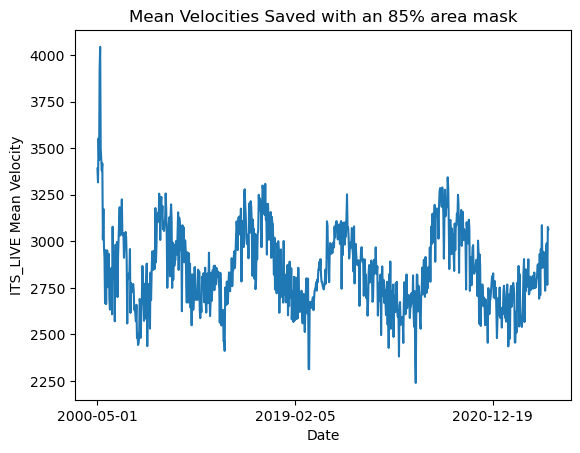

In [126]:
# plot the result
plt.plot(df['Date'],df['ITS_LIVE Mean Velocity'],linestyle='-')

plt.xlabel('Date')
plt.ylabel('ITS_LIVE Mean Velocity')
plt.title('Mean Velocities Saved with an 85% area mask')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.show()

In [128]:
# save the time series
df.to_csv(r'time_series_results/ITS_LIVE_velocity_area_mean_'+glacier+'.csv')

## Thoughts
Given that we'll be extrapolating the data anyway, I don't think it's too much of a foul to include data up to a 80% inclusion mask. We didn't quite get back to 2000-01-01, but got close enough that I think I can create a valid time series.

In [13]:
cpus = cpu_count() 
cpus

4

In [14]:
manual_chunk = int(kuj_vels.mid_date.shape[0]/cpus)
manual_chunk

12368

In [15]:
kuj_vels_chunk = kuj_vels.chunk({"mid_date": manual_chunk}) # setting the mid_date chunksize to the time dimensions helps A LOT
kuj_vels_chunk = kuj_vels_chunk.sortby('mid_date')

In [16]:
kuj_vels_chunk

<xarray.Dataset>
Dimensions:                     (mid_date: 49475, y: 834, x: 833)
Coordinates:
  * mid_date                    (mid_date) datetime64[ns] 1984-10-21T14:23:16...
  * x                           (x) float64 -1.999e+05 -1.997e+05 ... -1e+05
  * y                           (y) float64 -2.1e+06 -2.1e+06 ... -2.2e+06
Data variables: (12/60)
    M11                         (mid_date, y, x) float32 dask.array<chunksize=(12368, 20, 20), meta=np.ndarray>
    M11_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(12368,), meta=np.ndarray>
    M12                         (mid_date, y, x) float32 dask.array<chunksize=(12368, 20, 20), meta=np.ndarray>
    M12_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(12368,), meta=np.ndarray>
    acquisition_date_img1       (mid_date) datetime64[ns] dask.array<chunksize=(12368,), meta=np.ndarray>
    acquisition_date_img2       (mid_date) datetime64[ns] dask.array<chunksize=(12368,), meta=np.ndarray>
    ...                          ...
    vy_error_modeled            (mid_date) float32 dask.array<chunksize=(12368,), meta=np.ndarray>
    vy_error_slow               (mid_date) float32 dask.array<chunksize=(12368,), meta=np.ndarray>
    vy_error_stationary         (mid_date) float32 dask.array<chunksize=(12368,), meta=np.ndarray>
    vy_stable_shift             (mid_date) float32 dask.array<chunksize=(12368,), meta=np.ndarray>
    vy_stable_shift_slow        (mid_date) float32 dask.array<chunksize=(12368,), meta=np.ndarray>
    vy_stable_shift_stationary  (mid_date) float32 dask.array<chunksize=(12368,), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               26-Sep-2023 03:06:33
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N70W040/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N70W040/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

In [17]:
vel_ts_list = []

In [28]:
for i in range(cpus):
    chunked_vel = kuj_vels.isel(mid_date=slice(i*manual_chunk,manual_chunk*(i+1))) # select the range of data from beginning to end of chunk size
    vel_ts_list.append(chunked_vel)

In [149]:
str(vel_ts_list[-1].mid_date[-1].dt.strftime('%Y-%m-%d').data)

'2022-12-22'

In [73]:

def date_sep_filter(dataset):
    date_dt_threshold = 1296000000000000 # Define the threshold in nanoseconds (15 days)

    # set the threshold as an xarray
    date_dt_threshold = xr.DataArray(date_dt_threshold, coords=dataset.date_dt.coords, dims=kuj_vels.date_dt.dims)
    date_dt_mask = dataset.date_dt <= date_dt_threshold # Create a boolean mask based on the condition
    date_dt_mask = date_dt_mask.compute()
    kuj_vels_filt = dataset.where(date_dt_mask, drop=True) # Apply the mask to filter the dataset

    # setup variables into useful formats
    kuj_vels_filt = kuj_vels_filt.rio.write_crs('EPSG:3413')
    kuj_vels_filt.rio.transform()
    pixel_mask_threshold = float(0.80) # ie- only keep data if __%+ of the polygon is there

    return kuj_vels_filt



def term_filter(dataset_filtered, term_poly_dir=f'{glacier}_polygons/'):
    # remove data with no terminus pick within 30 days
    # List the dates of all the .shp files in the directory
    files = os.listdir(terminus_poly_dir)
    shp_files = [file for file in files if file.endswith('.shp')] # Filter only the .shp files
    date_format = '%Y_%m_%d'
    terminus_dates = [datetime.strptime(shp_file[:10], date_format) for shp_file in shp_files]
    terminus_dates = [date.strftime('%Y-%m-%d') for date in terminus_dates]
    terminus_dates = pd.to_datetime(terminus_dates)
    
    time_window = timedelta(days=30) # Define the time window (30 days)
    valid_indices = [] # empty list
    # Iterate over each mid_date in kuj_vels_filt
    for index, mid_date in enumerate(kuj_vels_filt.mid_date.values):
        mid_date = pd.to_datetime(mid_date)  # Convert to pandas datetime for comparison
        # Check if mid_date is within 30 days of any date in terminus_dates
        if any(abs(mid_date - date) <= time_window for date in terminus_dates):
            valid_indices.append(index)
    
    # filter kuj_vels_filt
    dataset_filtered = dataset_filtered.isel(mid_date=np.array(valid_indices))
    
    return dataset_filtered, terminus_dates



def poly_sample(dataset,term_poly_dir=f'{glacier}_polygons/'):
    
    # Iterate over each mid_date in kuj_vels_filt_clip
    saved_means       = []
    saved_dates       = []
    saved_coverage    = []
    filtered_datasets = []
    for mid_date in dataset.mid_date.values:
        mid_date = pd.to_datetime(mid_date)  # Convert to pandas datetime
        
        # Find the nearest date in terminus_dates
        nearest_date = min(terminus_dates, key=lambda x: abs(x - mid_date))
        
        # Formulate the filename based on the nearest date
        filename = nearest_date.strftime('%Y_%m_%d_term_polygon.shp')
        filepath = os.path.join(terminus_poly_dir, filename)
        
        # Import the related .shp file as clip_poly
        glacier_poly = gpd.read_file(filepath)
        kuj_poly_3413 = clip_poly.to_crs(3413)
        dataset_filt_clip = dataset.rio.clip(glacier_poly.geometry.values,
                                                    glacier_poly.crs, drop=True, invert=False)
        
        # Compute pixel_mask
        data = dataset_filt_clip.v.sel(mid_date=mid_date)
        pixel_area = np.sum(~np.isnan(data.values)) * 120 * 120
        pixel_mask = pixel_area / glacier_poly.area
        
        # Check if all values in pixel_mask meet the condition
        if (pixel_mask > pixel_mask_threshold).all():
            mean_value = np.nanmean(dataset_filt_clip.v.sel(mid_date=mid_date).values)
            # filtered_datasets.append(kuj_vels_filt_clip)
            saved_means.append(mean_value)
            saved_dates.append(mid_date)
            saved_coverage.append(pixel_mask)
    
    # Combine the filtered variables into a single DataArray
    # kuj_vels_final = xr.concat(filtered_datasets, dim='mid_date')
    
    return saved_means, saved_dates, saved_coverage

def convert_to_dataframe(saved_means, saved_dates, saved_coverage):

    # reformat the saved lists before adding them to a df
    saved_coverage_float  = []
    saved_coverage_float  = [round(entry[0],3) for entry in saved_coverage]
    saved_dates_formatted = pd.to_datetime(saved_dates, format="Timestamp('%Y-%m-%d %H:%M:%S.%f')").strftime('%Y-%m-%d')
    saved_means_rounded = [round(entry,1) for entry in saved_means]
    df = pd.DataFrame({'Date':saved_dates_formatted,'ITS_LIVE Mean Velocity':saved_means_rounded,'Mask Ratio':saved_coverage_float})
    # remove entries with the same date, keeping the one with the highest mask ratio
    idx_to_keep = df.groupby('Date')['Mask Ratio'].idxmax()
    df = df.loc[idx_to_keep]
    
    return df


def worker_func(dataset):
    dataset_filtered = date_sep_filter(dataset)
    saved_means_list, saved_dates_list, saved_coverage_list = poly_sample(dataset_filtered)
    timeseries_df = convert_to_dataframe(saved_means_list, saved_dates_list, saved_coverage_list)
    
    

In [36]:
if __name__ == "__main__":
    with Pool(processes=cpu_count()) as pool: # use all cpus if using some cloud computer or remote computer otherwise subtract a few cores
          results = pool.map(worker_func, vel_ts_list)

KeyboardInterrupt: 

In [44]:

path = './geoms/2020_12_11_term_polygon.shp'
kuj_poly = gpd.read_file(path)
kuj_centroid = kuj_poly.centroid
kuj_centroid = gpd.GeoDataFrame(geometry=kuj_centroid)#,crs=4326)
granule = catalog.sjoin(kuj_centroid, how='inner')
url = granule['zarr_url'].values[0]

kuj_vels = read_in_s3(url)
kuj_vels = kuj_vels.chunk({"mid_date": len(kuj_vels.mid_date)}) # setting the mid_date chunksize to the time dimensions helps A LOT
kuj_vels = kuj_vels.sortby('mid_date')
kuj_vels = kuj_vels.isel(mid_date=slice(0,100))
date_dt_threshold = np.timedelta64(1296000000000000*4,'ns')
date_dt_mask = kuj_vels.date_dt <= date_dt_threshold # Create a boolean mask based on the condition
date_dt_mask = date_dt_mask.compute()
dataset_filtered = kuj_vels.where(date_dt_mask, drop=True) # Apply the mask to filter the dataset
# dataset_filtered = dataset_filtered.where(date_dt_mask, drop=True) # Apply the mask to filter the dataset
# kuj_vels = kuj_vels.isel(mid_date=date_dt_mask) # not working here
dataset_filtered = dataset_filtered.rio.write_crs('EPSG:3413')
pixel_size = dataset_filtered.rio.transform()[0] # pixel size
# read in all terminus-based polygons for the glacier
glacier = 'KUJ'

def mega_function(dataset_filtered, term_poly_dir=f'{glacier}_polygons/',pixel_mask_threshold = float(0.80),
                  ps=pixel_size):
    # remove data with no terminus pick within 30 days
    # List the dates of all the .shp files in the directory
    print('term_filter start\n')
    files = os.listdir(terminus_poly_dir)
    shp_files = [file for file in files if file.endswith('.shp')] # Filter only the .shp files
    date_format = '%Y_%m_%d'
    terminus_dates = [datetime.strptime(shp_file[:10], date_format) for shp_file in shp_files]
    terminus_dates = [date.strftime('%Y-%m-%d') for date in terminus_dates]
    terminus_dates = pd.to_datetime(terminus_dates)
    
    time_window = timedelta(days=30) # Define the time window (30 days)
    valid_indices = [] # empty list
    # Iterate over each mid_date in kuj_vels_filt
    for index, mid_date in enumerate(dataset_filtered.mid_date.values):
        mid_date = pd.to_datetime(mid_date)  # Convert to pandas datetime for comparison
        # Check if mid_date is within 30 days of any date in terminus_dates
        if any(abs(mid_date - date) <= time_window for date in terminus_dates):
            valid_indices.append(index)
    
    # filter kuj_vels_filt
    print(f'valid indices: {valid_indices}')
    dataset_filtered = dataset_filtered.isel(mid_date=np.array(valid_indices))
    print('term_filter done\n')
    

    
    print('start poly_sample\n')
    # Iterate over each mid_date in kuj_vels_filt_clip
    saved_means       = []
    saved_dates       = []
    saved_coverage    = []
    filtered_datasets = []
    print(f'{len(dataset_filtered.mid_date.values)}')
    for mid_date in dataset_filtered.mid_date.values:
        mid_date = pd.to_datetime(mid_date)  # Convert to pandas datetime
        
        # Find the nearest date in terminus_dates
        nearest_date = min(terminus_dates, key=lambda x: abs(x - mid_date))
        
        # Formulate the filename based on the nearest date
        filename = nearest_date.strftime('%Y_%m_%d_term_polygon.shp')
        filepath = os.path.join(terminus_poly_dir, filename)
        
        # Import the related .shp file as clip_poly
        print('read shapefile\n')
        glacier_poly = gpd.read_file(filepath)
        glacier_poly = glacier_poly.to_crs(3413)
        dataset_filt_clip = dataset_filtered.rio.clip(glacier_poly.geometry.values,
                                                    glacier_poly.crs, drop=True, invert=False)
        print('start Compute pixel_mask\n')
        # Compute pixel_mask
        velocity_pixels = dataset_filt_clip.v.sel(mid_date=mid_date)
        print('grabbed data\n')
        # test = np.sum(~np.isnan(np.array([1,2,3,4])))
        print('passed')
        # count = np.count_nonzero(~np.isnan(velocity_pixels))
        print('passed 2')
        velocity_pixels_arr = Array(velocity_pixels.values.flatten())
        print('passed 3')
        pixel_area = np.sum(~np.isnan(velocity_pixels_arr)) * ps * ps
        print('pixel mask start\n')
        pixel_mask = pixel_area / glacier_poly.area
        
        # pixel_mask_threshold = float(0.80) # ie- only keep data if __%+ of the polygon is there
        
        # Check if all values in pixel_mask meet the condition
        print('check pixel mask values\n')
        if (pixel_mask > pixel_mask_threshold).all():
            mean_value = np.nanmean(dataset_filt_clip.v.sel(mid_date=mid_date).values)
            # filtered_datasets.append(kuj_vels_filt_clip)
            saved_means.append(mean_value)
            saved_dates.append(mid_date)
            saved_coverage.append(pixel_mask)
            
        # mean_value = np.nanmean(dataset_filt_clip.v.sel(mid_date=mid_date).values)
        # # filtered_datasets.append(kuj_vels_filt_clip)
        # saved_means.append(mean_value)
        # saved_dates.append(mid_date)
        # saved_coverage.append(pixel_mask)
    # Combine the filtered variables into a single DataArray
    # kuj_vels_final = xr.concat(filtered_datasets, dim='mid_date')
    first_date = str(dataset_filt_clip.mid_date[0].dt.strftime('%Y-%m-%d').data)
    last_date = str(dataset_filt_clip.mid_date[-1].dt.strftime('%Y-%m-%d').data)
    print('end poly_sample\n')
    

    print('start save df\n')
    # reformat the saved lists before adding them to a df
    saved_coverage_float  = []
    saved_coverage_float  = [round(entry[0],3) for entry in saved_coverage]
    saved_dates_formatted = pd.to_datetime(saved_dates, format="Timestamp('%Y-%m-%d %H:%M:%S.%f')").strftime('%Y-%m-%d')
    saved_means_rounded = [round(entry,1) for entry in saved_means]
    df = pd.DataFrame({'Date':saved_dates_formatted,'ITS_LIVE Mean Velocity':saved_means_rounded,'Mask Ratio':saved_coverage_float})
    # remove entries with the same date, keeping the one with the highest mask ratio
    idx_to_keep = df.groupby('Date')['Mask Ratio'].idxmax()
    df = df.loc[idx_to_keep]
    
    out_path = './velocity_dfs/'

    out_file = f'{out_path}{first_date}_{last_date}.csv'
    df.to_csv(out_file)
    print(f'saved {out_file}')
    
    return 

/tmp/ipykernel_502849/3659350280.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  kuj_centroid = kuj_poly.centroid


In [46]:
from dask.distributed import Client, progress, LocalCluster
cluster = LocalCluster(n_workers = 4)
c = Client(cluster)

future = c.map(mega_function, vel_ts_list)
results = c.gather(future)
results

/home/laserglaciers/anaconda3/envs/its_live_tutorial/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44697 instead
  warnings.warn(
/home/laserglaciers/anaconda3/envs/its_live_tutorial/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 24.59 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-02-06 17:20:05,484 - distributed.worker - WARNING - Compute Failed
Key:       mega_function-eca51141192c6de2e77e3e3516089e9b
Function:  mega_function
args:      (<xarray.Dataset>
Dimensions:                     (mid_date: 0, y: 834, x: 833)
Coordinates:
  * mid_date                    (mid_date) datetime64[ns] 
  * x                           (x) float64 -1.999e+05 -1.997e+05 ... -1e+05
  * y                           (y) float64 -2.1e+06 -2.1e+06 ... -2.2e+06
Data va

UnboundLocalError: local variable 'dataset_filt_clip' referenced before assignment

2024-02-06 17:20:05,617 - distributed.worker - WARNING - Compute Failed
Key:       mega_function-1b80747c63dc9b77c31996b8a969616f
Function:  mega_function
args:      (<xarray.Dataset>
Dimensions:                     (mid_date: 100, y: 834, x: 833)
Coordinates:
  * mid_date                    (mid_date) datetime64[ns] 1984-10-21T14:23:16...
  * x                           (x) float64 -1.999e+05 -1.997e+05 ... -1e+05
  * y                           (y) float64 -2.1e+06 -2.1e+06 ... -2.2e+06
Data variables: (12/60)
    M11                         (mid_date, y, x) float32 dask.array<chunksize=(100, 20, 20), meta=np.ndarray>
    M11_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    M12                         (mid_date, y, x) float32 dask.array<chunksize=(100, 20, 20), meta=np.ndarray>
    M12_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    acquisition_date_img1       (mid_date) datetime64[ns] dask.array

In [35]:
valid_indices

NameError: name 'valid_indices' is not defined